### Матричные факторизации

В данной работе вам предстоит познакомиться с практической стороной матричных разложений.
Работа поделена на 4 задания:
1. Вам необходимо реализовать SVD разложения используя SGD на explicit данных
2. Вам необходимо реализовать матричное разложения используя ALS на implicit данных
3. Вам необходимо реализовать матричное разложения используя BPR на implicit данных
4. Вам необходимо реализовать матричное разложения используя WARP на implicit данных

Мягкий дедлайн 13 Октября (пишутся замечания, выставляется оценка, есть возможность исправить до жесткого дедлайна)

Жесткий дедлайн 20 Октября (Итоговая проверка)

In [1]:
import implicit
import numpy as np
import pandas as pd
import scipy.sparse as sp
from lightfm.datasets import fetch_movielens

/Users/nikolajkarasov/.pyenv/versions/3.7.9/envs/python379/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:10: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  "LightFM was compiled without OpenMP support. "


В данной работе мы будем работать с explicit датасетом movieLens, в котором представленны пары user_id movie_id и rating выставленный пользователем фильму

Скачать датасет можно по ссылке https://grouplens.org/datasets/movielens/1m/

In [2]:
ratings = pd.read_csv('data/ml-1m/ratings.dat', delimiter='::', header=None, 
        names=['user_id', 'movie_id', 'rating', 'timestamp'], 
        usecols=['user_id', 'movie_id', 'rating'], engine='python')

In [3]:
movie_info = pd.read_csv('data/ml-1m/movies.dat', delimiter='::', header=None, 
        names=['movie_id', 'name', 'category'], engine='python')

Explicit данные

In [4]:
ratings

,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
...,...,...,...
1000204,6040,1091,1
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4


Для того, чтобы преобразовать текущий датасет в Implicit, давайте считать что позитивная оценка это оценка >=4

In [5]:
implicit_ratings = ratings.loc[(ratings['rating'] >= 4)]

In [6]:
implicit_ratings.head(10)

,user_id,movie_id,rating
0,1,1193,5
3,1,3408,4
4,1,2355,5
6,1,1287,5
7,1,2804,5
8,1,594,4
9,1,919,4
10,1,595,5
11,1,938,4
12,1,2398,4


Удобнее работать с sparse матричками, давайте преобразуем DataFrame в CSR матрицы

In [7]:
users = implicit_ratings["user_id"]
movies = implicit_ratings["movie_id"]
user_item = sp.coo_matrix((np.ones_like(users), (users, movies)))
user_item_t_csr = user_item.T.tocsr()
user_item_csr = user_item.tocsr()

В качестве примера воспользуемся ALS разложением из библиотеки implicit

Зададим размерность латентного пространства равным 64, это же определяет размер user/item эмбедингов

In [8]:
model = implicit.als.AlternatingLeastSquares(factors=64, iterations=100, calculate_training_loss=True)

В качестве loss здесь всеми любимый RMSE

In [9]:
model.fit(user_item_t_csr)

  0%|          | 0/100 [00:00<?, ?it/s]

Построим похожие фильмы по 1 movie_id = Истории игрушек

In [10]:
movie_info.head(5)

,movie_id,name,category
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
get_similars = lambda item_id, model : [movie_info[movie_info["movie_id"] == x[0]]["name"].to_string() 
                                        for x in model.similar_items(item_id)]

Как мы видим, симилары действительно оказались симиларами.

Качество симиларов часто является хорошим способом проверить качество алгоритмов.

P.S. Если хочется поглубже разобраться в том как разные алгоритмы формируют разные латентные пространства, рекомендую загружать полученные вектора в tensorBoard и смотреть на сформированное пространство

In [12]:
get_similars(1, model)

['0    Toy Story (1995)',
 '3045    Toy Story 2 (1999)',
 "2286    Bug's Life, A (1998)",
 '33    Babe (1995)',
 '584    Aladdin (1992)',
 '2315    Babe: Pig in the City (1998)',
 '360    Lion King, The (1994)',
 '1526    Hercules (1997)',
 '2252    Pleasantville (1998)',
 '2692    Iron Giant, The (1999)']

Давайте теперь построим рекомендации для юзеров

Как мы видим юзеру нравится фантастика, значит и в рекомендациях ожидаем увидеть фантастику

In [13]:
get_user_history = lambda user_id, implicit_ratings : [movie_info[movie_info["movie_id"] == x]["name"].to_string() 
                                            for x in implicit_ratings[implicit_ratings["user_id"] == user_id]["movie_id"]]

In [14]:
get_user_history(4, implicit_ratings)

['3399    Hustler, The (1961)',
 '2882    Fistful of Dollars, A (1964)',
 '1196    Alien (1979)',
 '1023    Die Hard (1988)',
 '257    Star Wars: Episode IV - A New Hope (1977)',
 '1959    Saving Private Ryan (1998)',
 '476    Jurassic Park (1993)',
 '1180    Raiders of the Lost Ark (1981)',
 '1885    Rocky (1976)',
 '1081    E.T. the Extra-Terrestrial (1982)',
 '3349    Thelma & Louise (1991)',
 '3633    Mad Max (1979)',
 '2297    King Kong (1933)',
 '1366    Jaws (1975)',
 '1183    Good, The Bad and The Ugly, The (1966)',
 '2623    Run Lola Run (Lola rennt) (1998)',
 '2878    Goldfinger (1964)',
 '1220    Terminator, The (1984)']

Получилось! 

Мы действительно порекомендовали пользователю фантастику и боевики, более того встречаются продолжения тех фильмов, которые он высоко оценил

In [15]:
get_recommendations = lambda user_id, model : [movie_info[movie_info["movie_id"] == x[0]]["name"].to_string() 
                                               for x in model.recommend(user_id, user_item_csr)]

In [16]:
get_recommendations(4, model)

['585    Terminator 2: Judgment Day (1991)',
 '1271    Indiana Jones and the Last Crusade (1989)',
 '1284    Butch Cassidy and the Sundance Kid (1969)',
 '1182    Aliens (1986)',
 '2502    Matrix, The (1999)',
 '1178    Star Wars: Episode V - The Empire Strikes Back...',
 '1892    Rain Man (1988)',
 '1179    Princess Bride, The (1987)',
 '847    Godfather, The (1972)',
 '1884    French Connection, The (1971)']

Теперь ваша очередь реализовать самые популярные алгоритмы матричных разложений

Что будет оцениваться:
1. Корректность алгоритма
2. Качество получившихся симиларов
3. Качество итоговых рекомендаций для юзера

In [17]:
get_recommendations = lambda user_id, model, count : [movie_info[movie_info["movie_id"] == x[0]]["name"].to_string() 
                                               for x in model.recommend(user_id, count)]

In [18]:
%config InlineBackend.figure_format = 'retina'

### Задание 1. Не используя готовые решения, реализовать SVD разложение используя SGD на explicit данных

In [19]:
from scripts.svd import SVDModel

In [20]:
%%time
svd_model = SVDModel(data_frame=ratings, latent_size=30,
                     learning_rate=1e-2, lambda_=1e-5,
                     max_iterations=int(2.2e7), epsilon=1e-8,
                     verbose_step=int(2e6), lambda_bias=1e-6)
svd_model = svd_model.fit()

> 1          | RMSE - 0.0053384
> 2000000    | RMSE - 0.0009006
> 4000000    | RMSE - 0.0008717
> 6000000    | RMSE - 0.0008273
> 8000000    | RMSE - 0.0007825
> 10000000   | RMSE - 0.0007543
> 12000000   | RMSE - 0.0007343
> 14000000   | RMSE - 0.0007258
> 16000000   | RMSE - 0.0007086
> 18000000   | RMSE - 0.0007006
> 20000000   | RMSE - 0.0006944
> 22000000   | RMSE - 0.0006874
CPU times: user 20min 21s, sys: 46.5 s, total: 21min 8s
Wall time: 20min 31s


In [21]:
get_similars(1, svd_model)

['0    Toy Story (1995)',
 '3045    Toy Story 2 (1999)',
 "2286    Bug's Life, A (1998)",
 '584    Aladdin (1992)',
 '2707    Marcello Mastroianni: I Remember Yes, I Rememb...',
 '1508    Shiloh (1997)',
 '3670    Trouble in Paradise (1932)',
 '104    Nobody Loves Me (Keiner liebt mich) (1994)',
 '2980    How I Won the War (1967)',
 '527    Secret Garden, The (1993)']

In [22]:
get_recommendations(4, svd_model, 10)

['1211    Annie Hall (1977)',
 '847    Godfather, The (1972)',
 '1203    Godfather: Part II, The (1974)',
 '1194    Third Man, The (1949)',
 '1224    Manhattan (1979)',
 '1185    12 Angry Men (1957)',
 '1274    M*A*S*H (1970)',
 '900    Casablanca (1942)',
 '1189    To Kill a Mockingbird (1962)',
 '1232    Chinatown (1974)']

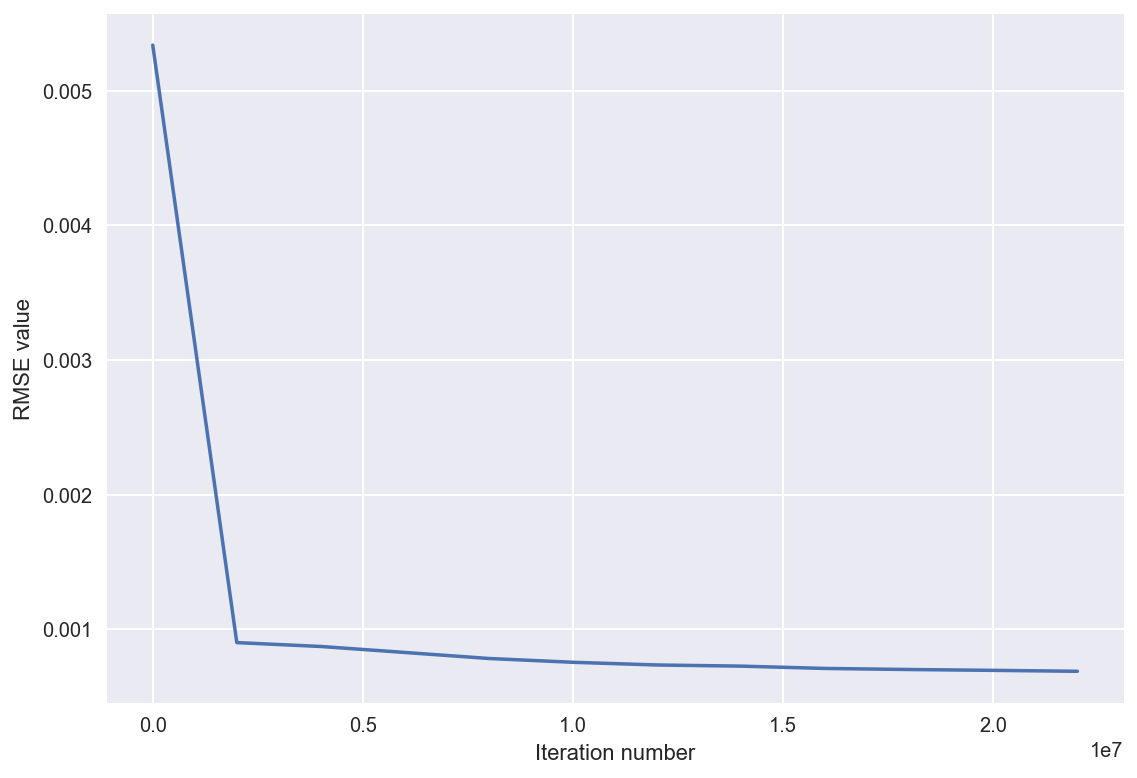

In [23]:
svd_model.plot_train_log()

### Задание 2. Не использую готовые решения, реализовать матричное разложение используя ALS на implicit данных

In [24]:
from scripts.als import ALSModel

In [25]:
%%time
als_model = ALSModel(data_frame=implicit_ratings, latent_size=32,
                     learning_rate=1e-3, lambda_=1e-3,
                     epsilon=1e-6, max_iterations=100,
                     verbose_step=10)
als_model = als_model.fit()

> 1          | RMSE - 0.0055317
> 10         | RMSE - 0.0048029
> 20         | RMSE - 0.0045665
> 30         | RMSE - 0.0042954
> 40         | RMSE - 0.0041519
> 50         | RMSE - 0.0040481
> 60         | RMSE - 0.0039862
> 70         | RMSE - 0.0039557
> 80         | RMSE - 0.0039415
> 90         | RMSE - 0.0039341
> 100        | RMSE - 0.0039297
CPU times: user 1min 14s, sys: 37.1 s, total: 1min 51s
Wall time: 37.6 s


In [26]:
get_similars(1, als_model)

['0    Toy Story (1995)',
 '3045    Toy Story 2 (1999)',
 "2286    Bug's Life, A (1998)",
 '584    Aladdin (1992)',
 '33    Babe (1995)',
 '360    Lion King, The (1994)',
 '2252    Pleasantville (1998)',
 '2692    Iron Giant, The (1999)',
 '591    Beauty and the Beast (1991)',
 '1205    Grand Day Out, A (1992)']

In [27]:
get_recommendations(4, als_model, 10)

['1178    Star Wars: Episode V - The Empire Strikes Back...',
 '1271    Indiana Jones and the Last Crusade (1989)',
 '1192    Star Wars: Episode VI - Return of the Jedi (1983)',
 '1182    Aliens (1986)',
 '585    Terminator 2: Judgment Day (1991)',
 '1284    Butch Cassidy and the Sundance Kid (1969)',
 '2502    Matrix, The (1999)',
 '453    Fugitive, The (1993)',
 '108    Braveheart (1995)',
 '1203    Godfather: Part II, The (1974)']

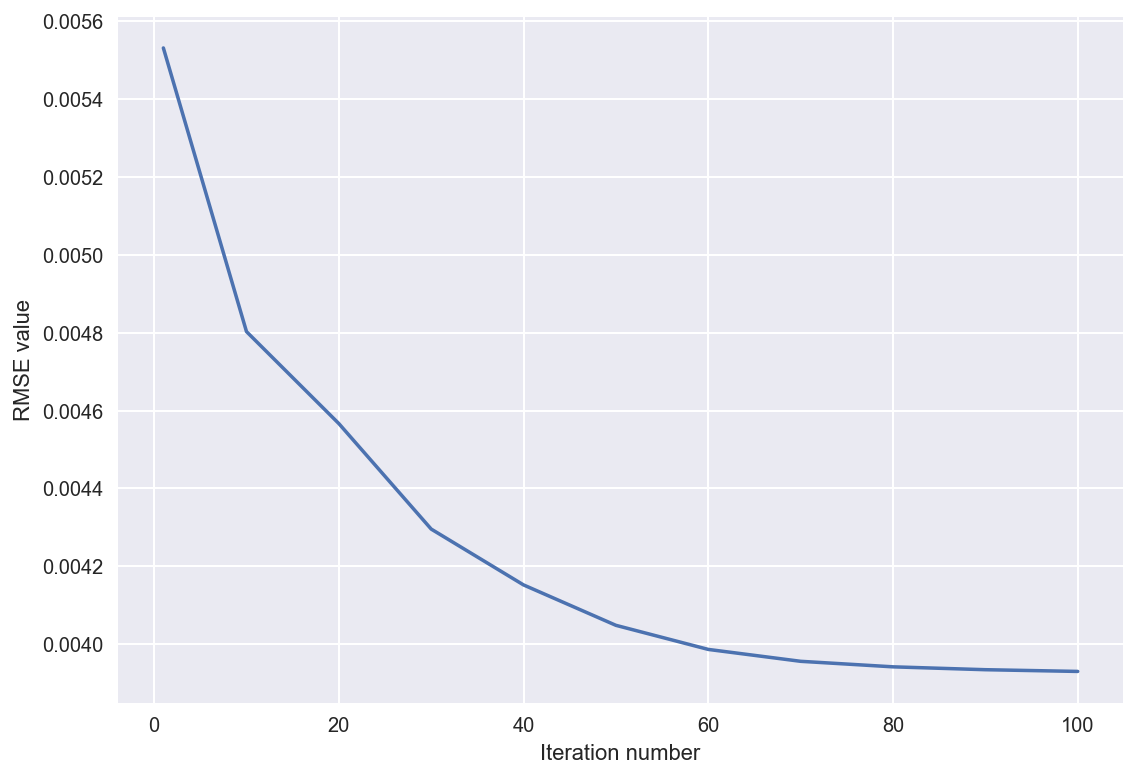

In [28]:
als_model.plot_train_log()

### Задание 3. Не использую готовые решения, реализовать матричное разложение BPR на implicit данных

In [29]:
implicit_ratings.user_id.unique() - 1

array([   0,    1,    2, ..., 6037, 6038, 6039])

In [30]:
from scripts.bpr import BPRModel

In [31]:
%%time
bpr_model = BPRModel(data_frame=implicit_ratings, latent_size=64,
                     learning_rate=1e-2, lambda_=1e-4, epsilon=1e-6,
                     max_iterations=7, verbose_step=1)
bpr_model = bpr_model.fit()

> 1          | RMSE - 0.0030162
> 2          | RMSE - 0.0027771
> 3          | RMSE - 0.0026607
> 4          | RMSE - 0.0025565
> 5          | RMSE - 0.0024851
> 6          | RMSE - 0.0024615
> 7          | RMSE - 0.0024791
CPU times: user 19min 32s, sys: 6.66 s, total: 19min 38s
Wall time: 19min 33s


In [32]:
get_similars(1, bpr_model)

['0    Toy Story (1995)',
 '1179    Princess Bride, The (1987)',
 "2286    Bug's Life, A (1998)",
 '1245    Groundhog Day (1993)',
 '3045    Toy Story 2 (1999)',
 '2918    Who Framed Roger Rabbit? (1988)',
 '1239    Stand by Me (1986)',
 '1250    Back to the Future (1985)',
 '584    Aladdin (1992)',
 '2647    Ghostbusters (1984)']

In [33]:
get_recommendations(4, bpr_model, 10)

['1178    Star Wars: Episode V - The Empire Strikes Back...',
 '2789    American Beauty (1999)',
 '585    Terminator 2: Judgment Day (1991)',
 '589    Silence of the Lambs, The (1991)',
 '2693    Sixth Sense, The (1999)',
 '604    Fargo (1996)',
 '2502    Matrix, The (1999)',
 '1192    Star Wars: Episode VI - Return of the Jedi (1983)',
 '315    Shawshank Redemption, The (1994)',
 "523    Schindler's List (1993)"]

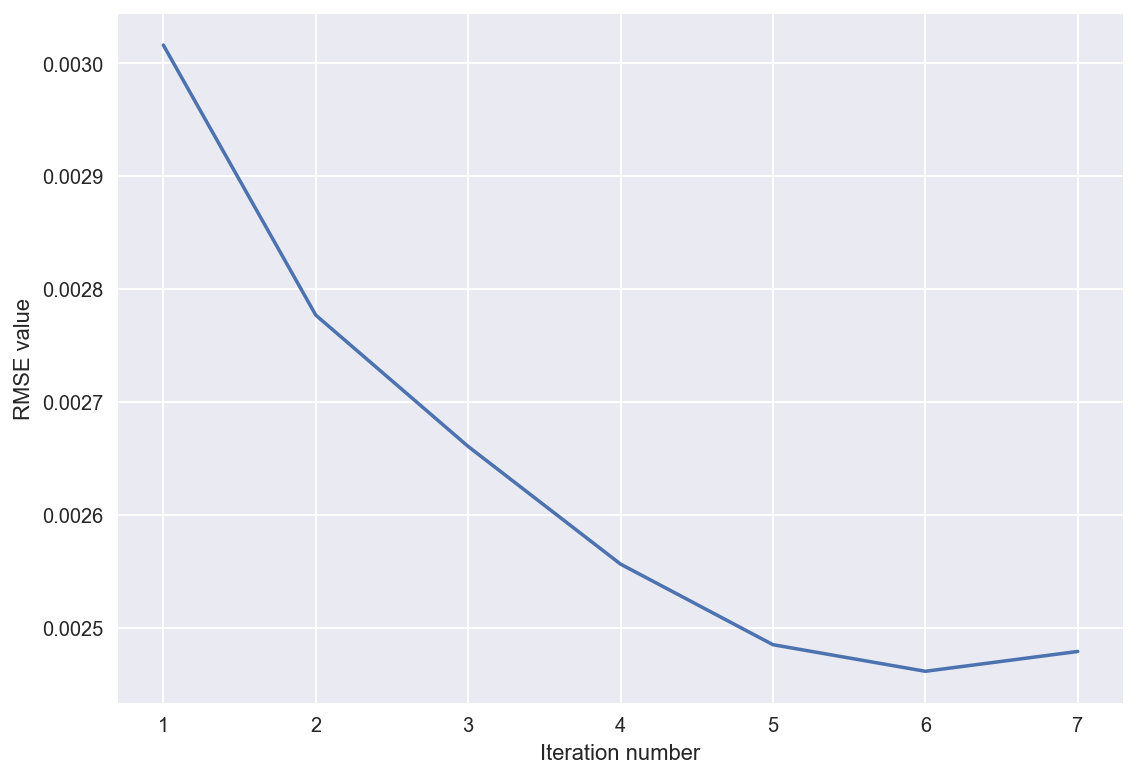

In [34]:
bpr_model.plot_train_log()

### Задание 4. Не использую готовые решения, реализовать матричное разложение WARP на implicit данных

In [35]:
from scripts.warp import WARPModel

In [36]:
%%time
warp_model = WARPModel(data_frame=implicit_ratings, latent_size=64,
                       learning_rate=1e-2, lambda_=1e-3, epsilon=1e-6,
                       max_iterations=5, verbose_step=1, sample_size=55)
warp_model = warp_model.fit()

> 1          | RMSE - 0.003064
> 2          | RMSE - 0.0027196
> 3          | RMSE - 0.0025105
> 4          | RMSE - 0.0023865
> 5          | RMSE - 0.0023296
CPU times: user 8min 46s, sys: 2.15 s, total: 8min 49s
Wall time: 8min 46s


In [37]:
get_similars(1, warp_model)

['0    Toy Story (1995)',
 '3045    Toy Story 2 (1999)',
 "2286    Bug's Life, A (1998)",
 '2225    Antz (1998)',
 '33    Babe (1995)',
 '2252    Pleasantville (1998)',
 '584    Aladdin (1992)',
 '2692    Iron Giant, The (1999)',
 '360    Lion King, The (1994)',
 '826    Matilda (1996)']

In [38]:
get_recommendations(4, warp_model, 10)

['585    Terminator 2: Judgment Day (1991)',
 '1178    Star Wars: Episode V - The Empire Strikes Back...',
 '2502    Matrix, The (1999)',
 '537    Blade Runner (1982)',
 '453    Fugitive, The (1993)',
 '1192    Star Wars: Episode VI - Return of the Jedi (1983)',
 '1182    Aliens (1986)',
 '1203    Godfather: Part II, The (1974)',
 '1884    French Connection, The (1971)',
 '1284    Butch Cassidy and the Sundance Kid (1969)']

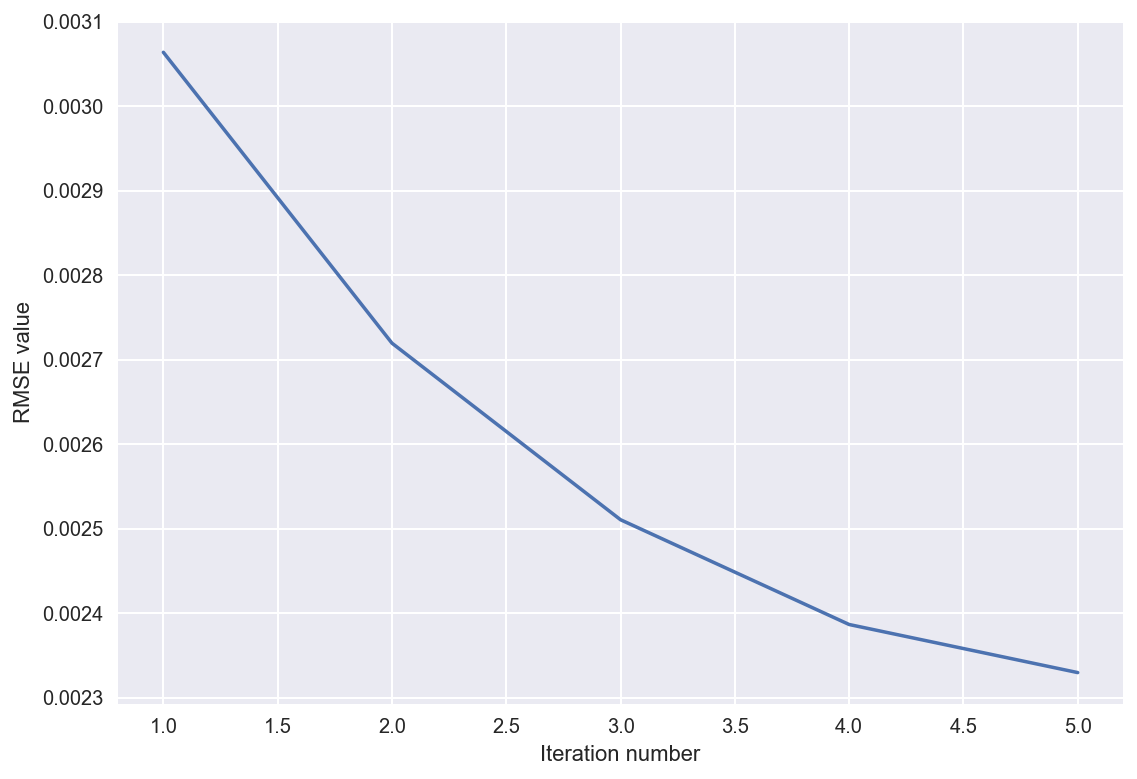

In [39]:
warp_model.plot_train_log()